# Big Mac Index — data analysis

Data from https://github.com/TheEconomist/big-mac-data

Notebook last updated Nov 2022

### Contents

- Intro
- A. Read data
- B. Clean data
- C. Investigation
    - i. How do Big Mac prices differ over time? (line graph)
    - ii. Which countries have the cheapest/most expensive Big Macs? (animated bar graph)
    - iii. How do Big Mac prices show changes in purchasing power? (line graph)
- D. Extra graphs
    - i. Correlation between Big Mac prices for different countries (heatmap/correlation matrix)
    - ii. Changes in Big Mac prices for various countries (horizontal bar graph)
    - iii. Big Mac prices over time (animated choropleth map)
- Key findings
- Limitations
- Miscellaneous

### Intro

Prices have ballooned recently, especially for essentials like petrol, groceries and [protein powder](https://www.reddit.com/r/dataisbeautiful/comments/xiear5/oc_protein_prices_are_going_outta_control/) (essential for gains). In order to save money, some people may opt for fast food, whose main selling point is its low prices. However, even fast food prices seem a little high recently, which got me thinking about the affordability of fast food. Luckily, we can look at the Big Mac Index, a dataset containing Big Mac prices, for some insights.

### What will this project focus on?

In this project, we will focus on finding answers to the following questions:
- How do Big Mac prices differ over time?
- Which countries have the cheapest/most expensive Big Macs?
- How do Big Mac prices show changes in purchasing power?

### What is the Big Mac Index?

The Big Mac Index records how much a Big Mac costs in various countries, and is updated once or twice a year. 

The Big Mac Index itself is based on the idea that the value of a Big Mac is the same regardless of where you buy it, so differences in prices should be accounted for by exchange rates. By comparing the actual exchange rate to the exchange rate suggested by Big Mac prices, we can see if a currency is undervalued or overvalued . 

For this analysis, I will be using the raw price and adjusted price of Big Macs, but not the Big Mac Index itself, which focuses more on comparing currency values and exchange rates.

### What is the difference between the raw price and the adjusted price of a Big Mac?

Raw price ('dollar_price'):
- Records the price of a Big Mac in different countries
- Local prices are converted directly to USD, based on exchange rate at the time

Adjusted price ('adj_price'):
- "The GDP-adjusted index addresses the criticism that you would expect average burger prices to be cheaper in poor countries than in rich ones because labour costs are lower."
- Adjusts raw price up/down based on regression between Big Mac prices and GDP per capita
    - **If raw price is adjusted up, a dollar goes "further" in that country (e.g. Vietnam)**
        - Price levels are lower in general, so the adjusted price is higher to make it more comparable
    - If raw price is adjusted down, a dollar does not "go as far" in that country (e.g. United States)
        - Price levels are higher in general, so the adjusted price is lower to make it more comparable
    - Not just comparing GDP per capita and adjusting it up if GDP per capita is low
- Attempt to reduce effect of different price levels in different economies
    - Same idea as PPP — converting currency into a defined set of goods (a Big Mac in this case)
    - A Big Mac should contribute the same amount to GDP, regardless of nominal cost (raw price)
    - ELI5: https://www.reddit.com/r/Economics/comments/25q4tm/eli5_what_are_the_differences_between_gdp_and/chk08fs/

Others:
- The Big Mac Index, used for exchange rate comparisons, is the 'USD_raw' column
    - Each country's Big Mac price is compared to the US price (but not the focus of this analysis)

### A. Read data
***

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# For displaying plotly graphs on nbviewer
    # Github displays static notebook, can't render plotly graphs
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

# Set default font and style for graphs
plt.rcParams["font.size"] = "15"
plt.rcParams["font.family"] = "serif" 
plt.rcParams["font.serif"] = "Helvetica Neue Bold", "Helvetica Neue", "serif" # Will pick first font available, otherwise default serif
plt.rcParams["text.usetex"] = False

# Set background color of graphs to white
    # Otherwise, background will be transparent making it hard to read titles in dark mode
plt.rcParams['figure.facecolor'] = 'white' 

pd.__version__

'1.4.1'

In [27]:
df = pd.read_csv("https://raw.githubusercontent.com/TheEconomist/big-mac-data/master/output-data/big-mac-full-index.csv", parse_dates=["date"])
# df = pd.read_csv("big-mac-full-index.csv", parse_dates=["date"]) # If using local version
# Drop unnecessary columns — these columns compare if currency is over/undervalued to base currency
    # df.columns for names of columns
df = df.drop(['USD_raw', 'EUR_raw', 'GBP_raw', 'JPY_raw', 'CNY_raw', 'USD_adjusted', 'EUR_adjusted','GBP_adjusted', 'JPY_adjusted', 'CNY_adjusted'], axis=1)

df.head(10) # Display first 10 rows

date iso_a3 currency_code            name  local_price   dollar_ex  \
0 2000-04-01    ARG           ARS       Argentina         2.50    1.000000   
1 2000-04-01    AUS           AUD       Australia         2.59    1.680000   
2 2000-04-01    BRA           BRL          Brazil         2.95    1.790000   
3 2000-04-01    CAN           CAD          Canada         2.85    1.470000   
4 2000-04-01    CHE           CHF     Switzerland         5.90    1.700000   
5 2000-04-01    CHL           CLP           Chile      1260.00  514.000000   
6 2000-04-01    CHN           CNY           China         9.90    8.280000   
7 2000-04-01    CZE           CZK  Czech Republic        54.37   39.100000   
8 2000-04-01    DNK           DKK         Denmark        24.75    8.040000   
9 2000-04-01    EUZ           EUR       Euro area         2.56    1.075269   

   dollar_price    GDP_bigmac  adj_price  
0      2.500000   7803.328512   1.922652  
1      1.541667  29144.876973   2.301550  
2      1.648045   4822.738983   1.869734  
3      1.938776  26087.329235   2.247266  
4      3.470588  23872.716095   2.207948  
5      2.451362   4640.836834   1.866505  
6      1.195652   1620.622125   1.812884  
7      1.390537   9020.845025   1.944267  
8      3.078358  21146.568676   2.159548  
9      2.380800           NaN        NaN

In [28]:
df.tail(10) # Display last 10 rows

date iso_a3 currency_code           name  local_price    dollar_ex  \
1621 2022-07-01    SGP           SGD      Singapore         5.90      1.39140   
1622 2022-07-01    SWE           SEK         Sweden        57.00     10.19785   
1623 2022-07-01    THA           THB       Thailand       128.00     36.61250   
1624 2022-07-01    TUR           TRY         Turkey        47.00     17.56500   
1625 2022-07-01    TWN           TWD         Taiwan        75.00     29.90750   
1626 2022-07-01    URY           UYU        Uruguay       255.00     41.91000   
1627 2022-07-01    USA           USD  United States         5.15      1.00000   
1628 2022-07-01    VEN           VES      Venezuela        10.00      5.67320   
1629 2022-07-01    VNM           VND        Vietnam     69000.00  23417.00000   
1630 2022-07-01    ZAF           ZAR   South Africa        39.90     17.03625   

      dollar_price    GDP_bigmac  adj_price  
1621      4.240333  85366.699398   4.826632  
1622      5.589413  46516.137374   4.151892  
1623      3.496074   9306.323554   3.505648  
1624      2.675776   9256.997784   3.504791  
1625      2.507732  64992.899747   4.472789  
1626      6.084467  14726.863618   3.599789  
1627      5.150000  69231.400000   4.546401  
1628      1.762674           NaN        NaN  
1629      2.946577   6375.564885   3.454747  
1630      2.342065  13261.543640   3.574340

### B. Clean data
***
Before we can use our data, we should look for null values or outliers. These could represent missing or wrongly recorded data, which could affect our analysis results.

In [29]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) 
# 'apply' removes scientific notation
# Not every entry has a GDP adjusted price — 1631 entries for raw index v.s. 1386 entries for adjusted index
# Not much data to clean otherwise — no null values for dollar_price, doesn't seem to be outliers with min and max (i.e. no values are 0 or absurdly large)

local_price      dollar_ex dollar_price   GDP_bigmac   adj_price
count      1631.00000     1631.00000   1631.00000   1386.00000  1386.00000
mean      18869.98682     5634.48011      3.32123  25301.13329     3.42131
std      430328.54656   109893.46573      1.27242  19799.78001     0.80159
min           1.05000        0.30080      0.63997      0.00221     1.55099
25%           7.64000        3.07070      2.38738   8245.88577     2.96026
50%          27.49000        7.75785      3.14420  20180.85919     3.38499
75%         130.50000       51.15875      4.05244  39933.90861     3.98542
max    16020000.00000  3613989.07100      9.08107  98893.85905     5.54346

Let's also tidy up country names and add a 'continent' column for each country.

In [30]:
# Rename UAE to United Arab Emirates — some entries use UAE, some use latter
print("Before — 'UAE' count: {}, 'United Arab Emirates' count: {}".format(len(df.loc[df["name"] == "UAE"]), len(df.loc[df["name"] == "United Arab Emirates"])))
df.loc[df["name"] == "UAE", "name"] = "United Arab Emirates"
print("After — 'UAE' count: {}, 'United Arab Emirates' count: {}".format(len(df.loc[df["name"] == "UAE"]), len(df.loc[df["name"] == "United Arab Emirates"])))
# df.loc[df["name"] == "UAE"] # Empty dataframe, since all entries with UAE have been renamed

Before — 'UAE' count: 22, 'United Arab Emirates' count: 9
After — 'UAE' count: 0, 'United Arab Emirates' count: 31


In [31]:
# Add a 'continent' column to dataframe, so we can group data by continent
# Group countries by continent (have to do it manually)
    # Should sort by iso_a3 code to avoid misspelt names, but I would have to look up what names correspond to what codes
north_america_australia = ["Australia", "Canada", "New Zealand", "United States"]
south_america = ["Argentina", "Brazil", "Chile", "Mexico", "Peru", "Venezuela", "Colombia", "Costa Rica", "Uruguay", "Guatemala", "Honduras", "Nicaragua"]
asia = ["China", "Hong Kong", "Japan", "South Korea", "Russia", "Taiwan", "Singapore"] 
south_east_asia = ["Indonesia", "Malaysia", "Thailand", "Phillippines", "Sri Lanka", "Pakistan", "India", "Vietnam"]
europe = ["Switzerland", "Denmark", "Euro area", "Britain", "Sweden", "Norway"]
east_europe = ["Czech Republic", "Euro area", "Hungary", "Poland", "Ukraine", "Azerbajian", "Croatia", "Moldova", "Romania"] 
africa_middle_east = ["Israel", "South Africa", "Turkey", "Egypt", "Saudi Arabia", "United Arab Emirates", "Bahrain", "Jordan", "Kuwait", "Lebanon", "Oman", "Qatar"]

def continent(country):
    if country in north_america_australia:
        return "North America + Australia"
    elif country in south_america:
        return "South America"
    elif country in asia:
        return "Asia"
    elif country in south_east_asia:
        return "South East Asia"
    elif country in europe:
        return "Western Europe"
    elif country in east_europe:
        return "Eastern Europe"
    elif country in africa_middle_east:
        return "Africa + Middle East"
    else:
        return None

df["continent"] = df["name"].apply(continent) # Apply the continent function to each row of dataframe
df = df.reindex(columns=['date', 'iso_a3', 'currency_code', 'continent', 'name', 'local_price', 'dollar_ex', 'dollar_price', 'GDP_bigmac', 'adj_price']) # Rearrange dataframe so 'continent' column is next to 'name' column
df.head()

date iso_a3 currency_code                  continent         name  \
0 2000-04-01    ARG           ARS              South America    Argentina   
1 2000-04-01    AUS           AUD  North America + Australia    Australia   
2 2000-04-01    BRA           BRL              South America       Brazil   
3 2000-04-01    CAN           CAD  North America + Australia       Canada   
4 2000-04-01    CHE           CHF             Western Europe  Switzerland   

   local_price  dollar_ex  dollar_price    GDP_bigmac  adj_price  
0         2.50       1.00      2.500000   7803.328512   1.922652  
1         2.59       1.68      1.541667  29144.876973   2.301550  
2         2.95       1.79      1.648045   4822.738983   1.869734  
3         2.85       1.47      1.938776  26087.329235   2.247266  
4         5.90       1.70      3.470588  23872.716095   2.207948

### C. Investigation
***
#### i. How do Big Mac prices differ across countries?

To get a general idea of how Big Mac prices change over time, let's plot Big Mac prices for each country on the same line graph. 

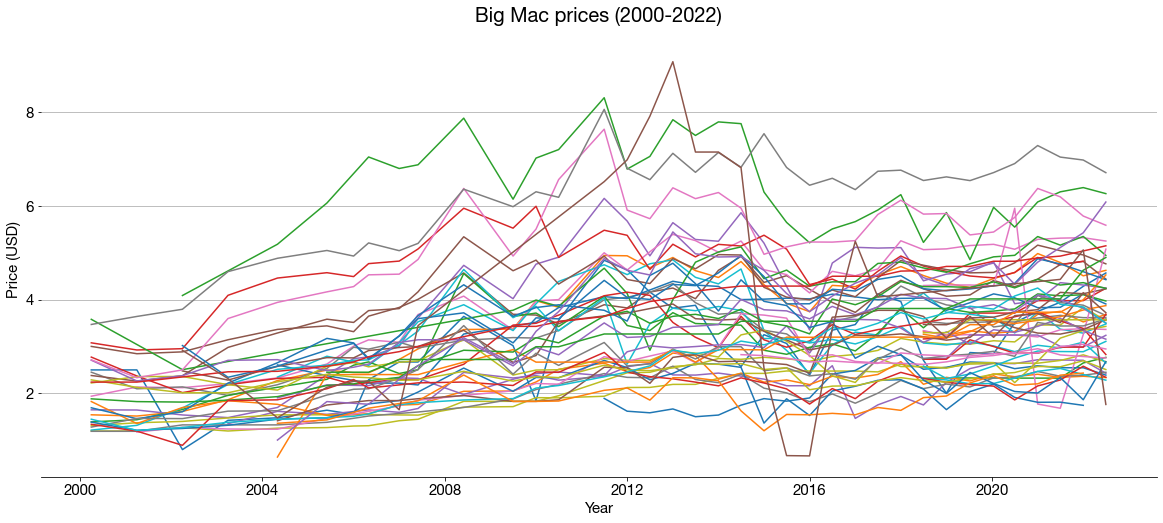

In [32]:
# Line graph — price changes for all countries, and visually see when prices went down
fig, ax = plt.subplots(figsize=(20, 8))

def plot_lines(df,x_axis,y_axis,**kwargs):
    ax.plot(df[x_axis],df[y_axis],**kwargs)

df.groupby("name").apply(plot_lines,"date","dollar_price") # For each unique value in "name" 

ax.set_title("Big Mac prices (2000-2022)", fontsize=20, pad=20) # Increase padding between graph and title
ax.set_ylabel("Price (USD)")
ax.set_xlabel("Year")
ax.grid(color='grey', axis="y", linestyle='-', linewidth=1, alpha=0.5) # alpha = opacity
ax.spines.right.set_visible(False) 
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)

This graph is pretty messy, and it would be hard to tell which line represents which country. It would be better if we separated countries into different graphs for easier comparison.

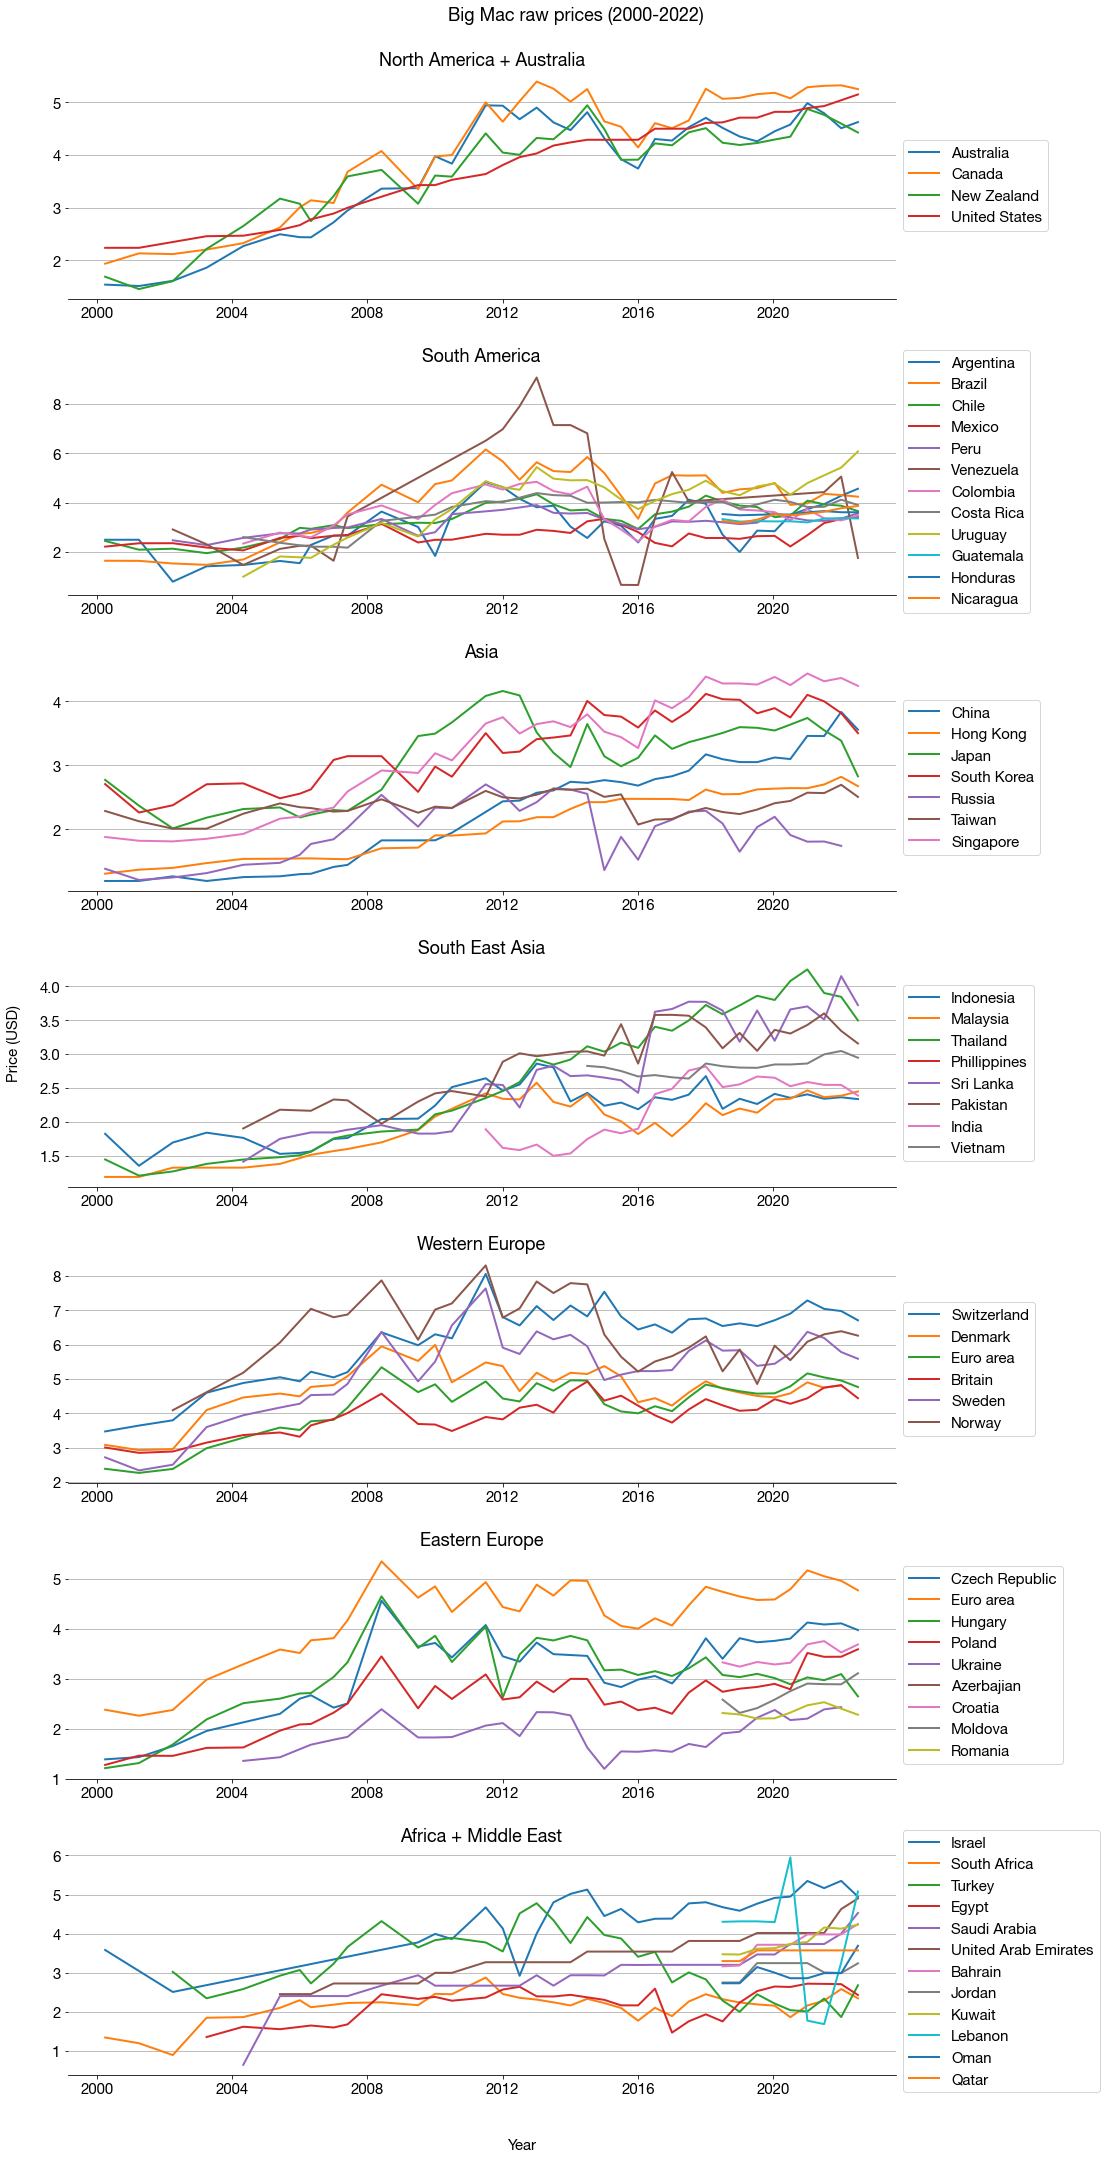

In [33]:
# Not realistic to make a subplot for each country (58 countries total), but would be able to use local prices for each
# Using US dollar prices keeps things more comparable and might be a better indicator of price increases, 
# since imports contribute to inflation and are done with foreign curency
# Plot US dollar_price v.s. date for each list
fig, ax = plt.subplots(7,1,figsize=(15,30)) # 7 rows, 1 column
  # 4 rows, 2 columns also works (ax[0,0] instead) but a bit cramped — need to zoom in to see figures

# Probably some way to make code below more efficient with an extra for loop, but not bothered to
for country in north_america_australia:
  ax[0].plot(df[df['name'] == country]['date'], df[df['name'] == country]['dollar_price'], linewidth=2, label=country)
ax[0].set_title("North America + Australia")

for country in south_america:
    ax[1].plot(df[df['name'] == country]['date'], df[df['name'] == country]['dollar_price'], linewidth=2, label=country)
ax[1].set_title("South America")

for country in asia:
  ax[2].plot(df[df['name'] == country]['date'], df[df['name'] == country]['dollar_price'], linewidth=2, label=country)
ax[2].set_title("Asia")

for country in south_east_asia:
  ax[3].plot(df[df['name'] == country]['date'], df[df['name'] == country]['dollar_price'], linewidth=2, label=country)
ax[3].set_title("South East Asia")

for country in europe:
  ax[4].plot(df[df['name'] == country]['date'], df[df['name'] == country]['dollar_price'], linewidth=2, label=country)
ax[4].set_title("Western Europe")

for country in east_europe:
  ax[5].plot(df[df['name'] == country]['date'], df[df['name'] == country]['dollar_price'], linewidth=2, label=country)
ax[5].set_title("Eastern Europe")

for country in africa_middle_east:
  ax[6].plot(df[df['name'] == country]['date'], df[df['name'] == country]['dollar_price'], linewidth=2, label=country)
ax[6].set_title("Africa + Middle East")

# Styling for each subplot
for i in range(len(ax)):
  ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Move legend to right of graph
  ax[i].grid(color='grey', axis="y", linestyle='-', linewidth=1, alpha=0.5) # Set major tick lines
  ax[i].spines.left.set_visible(False) # Remove margins
  ax[i].spines.right.set_visible(False) # Remove margins
  ax[i].spines.top.set_visible(False)  

fig.suptitle('Big Mac raw prices (2000-2022)') # Super title
fig.text(0.45, -0.01, 'Year', ha='center', va='center') # x-coordinate, y-coordinate, text, horizontal alignment, vertical alignment
fig.text(-0.02, 0.5, 'Price (USD)', ha='center', va='center', rotation='vertical')
plt.tight_layout() # Adjust spacing for graph
fig.subplots_adjust(top=0.95)

In general, it looks like countries within the same region follow a similar trend, but don't necessarily have a similar price. The only region with similar trend and price is North America and Australia.

Let's see if this changes if we used adjusted prices, instead of raw prices.

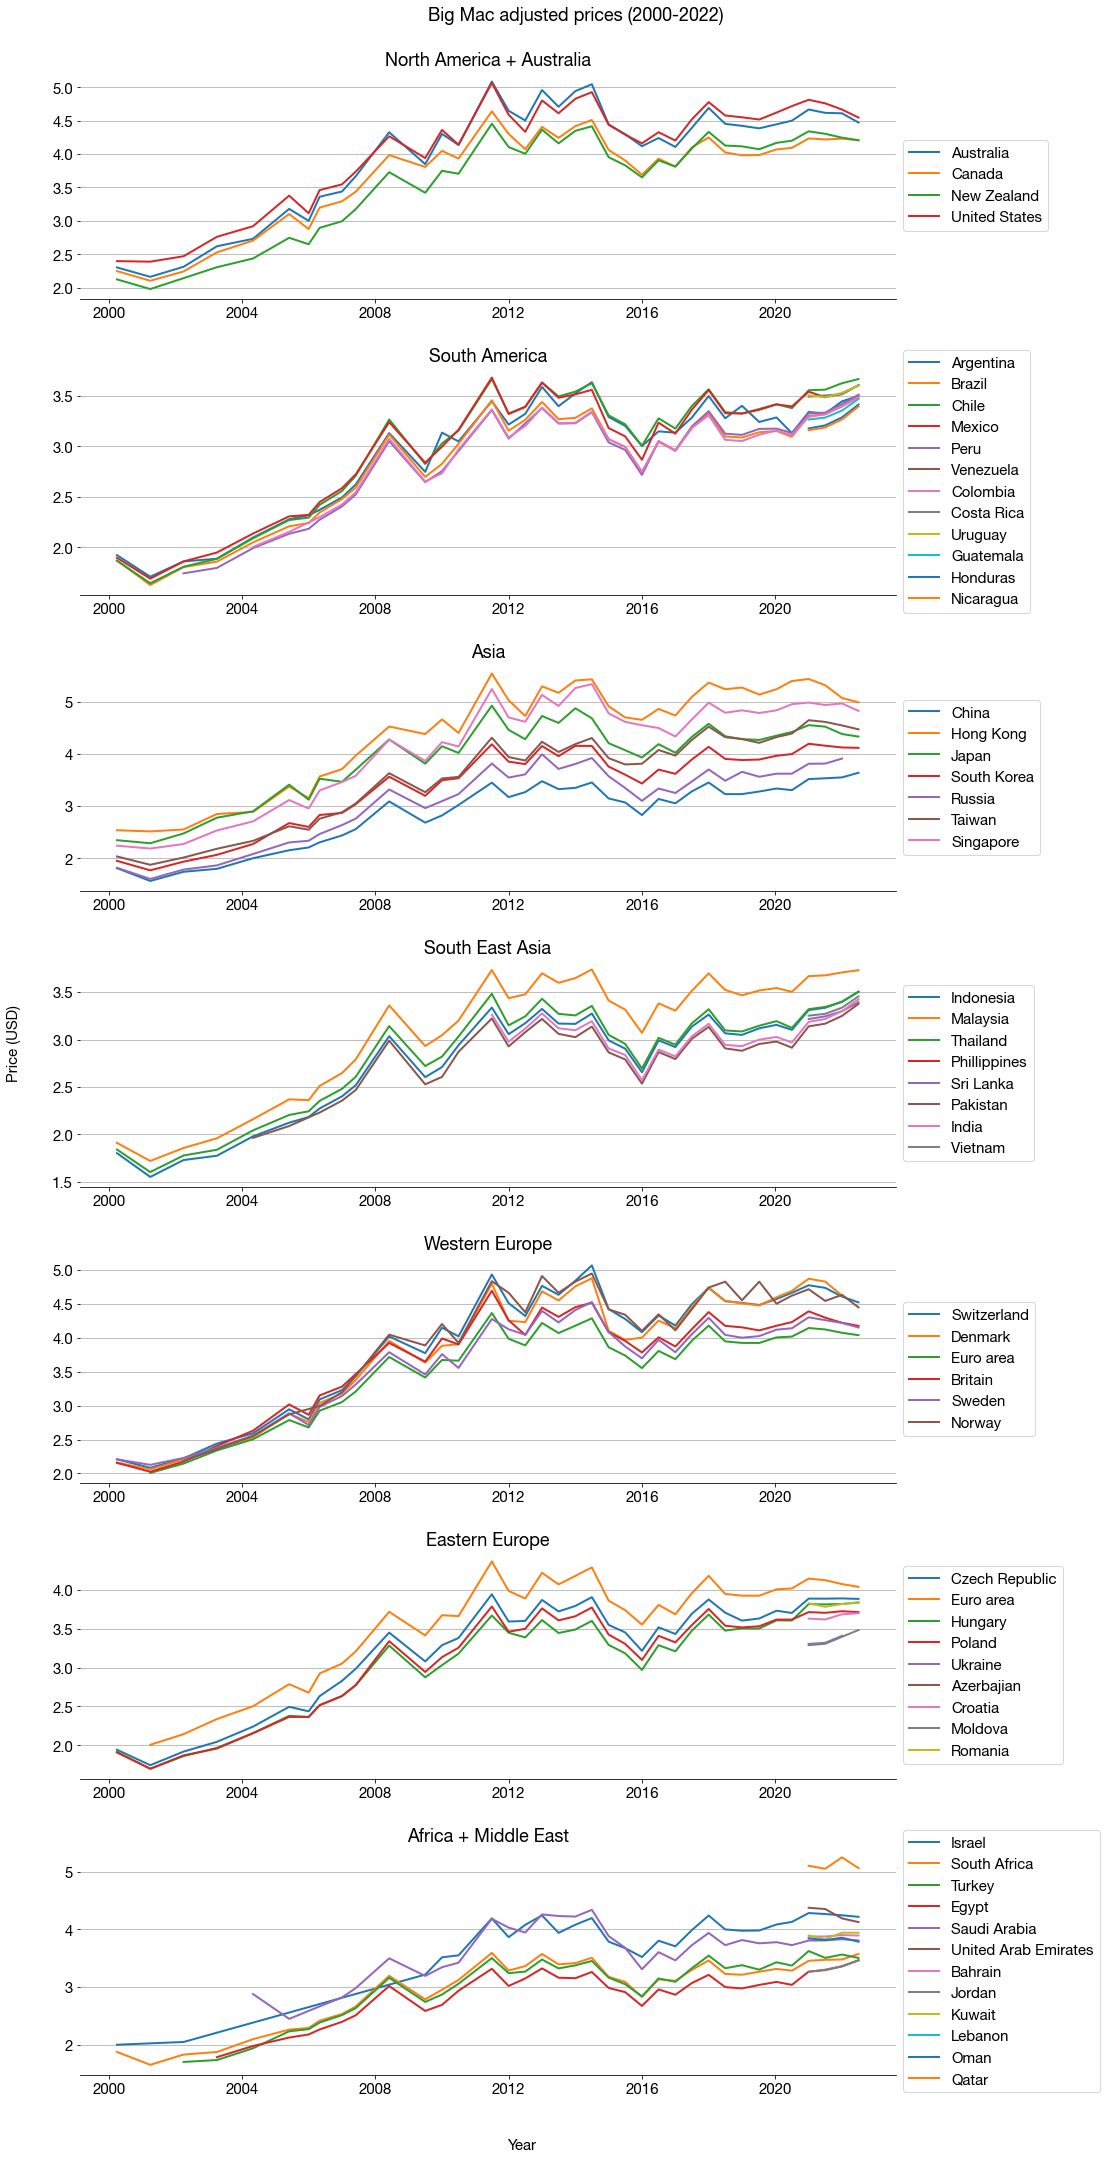

In [34]:
# Repeat using adjusted prices
# Plot US dollar_price v.s. date for each list
fig, ax = plt.subplots(7,1,figsize=(15,30)) # 7 rows, 1 column

for country in north_america_australia:
  ax[0].plot(df[df['name'] == country]['date'], df[df['name'] == country]['adj_price'], linewidth=2, label=country)
ax[0].set_title("North America + Australia")
for country in south_america:
    ax[1].plot(df[df['name'] == country]['date'], df[df['name'] == country]['adj_price'], linewidth=2, label=country)
ax[1].set_title("South America")
for country in asia:
  ax[2].plot(df[df['name'] == country]['date'], df[df['name'] == country]['adj_price'], linewidth=2, label=country)
ax[2].set_title("Asia")
for country in south_east_asia:
  ax[3].plot(df[df['name'] == country]['date'], df[df['name'] == country]['adj_price'], linewidth=2, label=country)
ax[3].set_title("South East Asia")
for country in europe:
  ax[4].plot(df[df['name'] == country]['date'], df[df['name'] == country]['adj_price'], linewidth=2, label=country)
ax[4].set_title("Western Europe")
for country in east_europe:
  ax[5].plot(df[df['name'] == country]['date'], df[df['name'] == country]['adj_price'], linewidth=2, label=country)
ax[5].set_title("Eastern Europe")
for country in africa_middle_east:
  ax[6].plot(df[df['name'] == country]['date'], df[df['name'] == country]['adj_price'], linewidth=2, label=country)
ax[6].set_title("Africa + Middle East")

for i in range(len(ax)):
  ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Move legend to right of graph
  ax[i].grid(color='grey', axis="y", linestyle='-', linewidth=1, alpha=0.5) # Set major tick lines
  ax[i].spines.left.set_visible(False) # Remove margins
  ax[i].spines.right.set_visible(False)
  ax[i].spines.top.set_visible(False)  

fig.suptitle('Big Mac adjusted prices (2000-2022)')
fig.text(0.45, -0.01, 'Year', ha='center', va='center') # x-coordinate, y-coordinate, text, horizontal alignment, vertical alignment
fig.text(-0.02, 0.5, 'Price (USD)', ha='center', va='center', rotation='vertical')
plt.tight_layout() # Adjust spacing for graph
fig.subplots_adjust(top=0.95)

After using adjusted prices, it looks like Big Mac prices within regions move more similarly and within a smaller price range. This suggests that the actual cost of a Big Mac doesn't differ as much as it would appear with the raw price/'sticker' price. 

In other words, even though a Big Mac may cost 5USD in the United States and 2.8USD in Japan in terms of raw prices, it costs around the same after adjusting for purchasing power (4.6USD for US compared to 4.4USD for Japan, using adjusted prices), since you can buy more goods with the same amount of money in Japan. 


#### ii. Which countries have the cheapest/most expensive Big Macs?

In [35]:
# Animated bar chart showing distribution of raw prices
df_plotly = df.copy(deep=True) # Make a deep copy of current dataframe, to avoid making changes to original dataframe
df_plotly["date"] = df_plotly["date"].astype('str') # Need to convert dates to string, for Plotly to process

fig = px.bar(df_plotly,
            x="name",
            y="dollar_price",
            animation_frame="date",
            color="continent",                                 # Color bars based on values in "continent" column
            color_discrete_map={                               # Maps continent names to color
                "North America + Australia": "greenyellow",
                "South America": "turquoise",
                "Asia": "green",
                "South East Asia": "green",
                "Western Europe": "skyblue",
                "Eastern Europe": "skyblue",
                "Africa + Middle East": "steelblue",
            },
            hover_data={
                "date": False,
                "dollar_price": True,
                "name": True
            },
            labels={
                "dollar_price": "Price (USD)",
                "name": "Country",
                "continent": "Continent"
            }            
            )

fig.update_layout(xaxis={'categoryorder':'total ascending'},  # Sort countries by ascending price
                    yaxis_range=[0,9],                        # Fix y-axis range throughout animation
                    xaxis_range=[-1,55],                      # Fix x-axis length throughout animation (otherwise new countries will get cut off)
                    width=1800,
                    height=800,
                    autosize=True,
                    title_text = 'Big Mac raw prices',
                    xaxis_title=None,                        # Remove x-axis title, otherwise will overlap with animation slider  
                    font_size=18,
                    font_family = "Helvetica Neue",
                    legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.01
                    )
                )

# Adjust animation speed
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2500 

# Move animation buttons further below plot, so that country names don't overlap
    # Can be wonky for different screen sizes, since this manually changes their positions
    # https://community.plotly.com/t/how-can-i-move-the-animation-play-button-and-slider-closer-to-the-plot/48646
    # Manually changing position of animation button and slider
fig.update_layout(updatemenus=[dict(type='buttons',
                  showactive=False,
                  y=-0.47,
                  x=0.02,
                  xanchor='left',
                  yanchor='bottom')
                        ])
# Move animation slider further below plot
fig['layout']['sliders'][0]['pad']=dict(r= 70, t=180)

fig.show()

# Extension: Fix graph size — have to zoom out for smaller screens
# Extension: For countries with no data for that date, fill in previously recorded price if it exists

Looks like Western European countries like Norway and Switzerland lead in raw Big Mac prices, while countries in Asia, Africa and the Middle East tend to have lower prices.

(Plotly charts are interactive, you can click on the legend to toggle specific continents)

In [36]:
# Animated bar chart showing distribution of adjusted prices
fig = px.bar(df_plotly,
            x="name",
            y="adj_price",
            animation_frame="date",
            color="continent",                                 # Color bars based on values in "continent" column
            color_discrete_map={                               # Maps continent names to color
                "North America + Australia": "greenyellow",
                "South America": "turquoise",
                "Asia": "green",
                "South East Asia": "green",
                "Western Europe": "skyblue",
                "Eastern Europe": "skyblue",
                "Africa + Middle East": "steelblue",
            },
            hover_data={
                "date": False,
                "adj_price": True,
                "name": True
            },
            labels={
                "adj_price": "Adjusted price (USD)",
                "name": "Country",
                "continent": "Continent"
            }            
            )

fig.update_layout(xaxis={'categoryorder':'total ascending'},  # Sort countries by ascending price
                    yaxis_range=[0,9],                        # Fix y-axis range throughout animation
                    xaxis_range=[-1,55],                      # Fix x-axis length throughout animation (otherwise new countries will get cut off)
                    width=1800,
                    height=800,
                    autosize=True,
                    title_text = 'Big Mac adjusted prices',
                    xaxis_title=None,                        # Remove x-axis title, otherwise will overlap with animation slider  
                    font_size=18,
                    font_family = "Helvetica Neue",
                    legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.01
                    )
                )

# Adjust animation speed
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2500 

# Move animation buttons further below plot, so that country names don't overlap
    # Can be wonky for different screen sizes, since this manually changes their positions
    # https://community.plotly.com/t/how-can-i-move-the-animation-play-button-and-slider-closer-to-the-plot/48646
    # Manually changing position of animation button and slider
fig.update_layout(updatemenus=[dict(type='buttons',
                  showactive=False,
                  y=-0.47,
                  x=0.02,
                  xanchor='left',
                  yanchor='bottom')
                        ])
# Move animation slider further below plot
fig['layout']['sliders'][0]['pad']=dict(r= 70, t=180)

fig.show()

After adjusting prices for purchasing power, it seems like Asia leads in both the top end and the low end of the price range. Hong Kong and Singapore consistenly have the highest adjusted prices, while India and Pakistan have the lowest.

To get a better sense of how differences in Big Mac prices have changed over the past 20 years, let's use a line graph to compare the minimum and maximum prices.

In [37]:
# Select relevant data
# For each date (data recorded every ~ 6 months, not every year), select the most and least expensive price to calculate range (also the country)
dates = df["date"].unique()

df_price_max = []
df_price_min = []

for date in dates:
    # Select only the date, name and dollar_price when date matches
    df_date = df.loc[df["date"] == date, ["date", "name", "dollar_price"]]

    max_row = df_date.loc[df_date["dollar_price"] == df_date["dollar_price"].max()] # Select row where dollar_price is max
    df_price_max.append(max_row)

    min_row = df_date.loc[df_date["dollar_price"] == df_date["dollar_price"].min()]
    df_price_min.append(min_row)

# Convert list into dataframe and tidy up index
df_price_max = pd.concat(df_price_max)
df_price_max = df_price_max.reset_index(drop=True)

df_price_min = pd.concat(df_price_min)
df_price_min = df_price_min.reset_index(drop=True)
# df_price_min

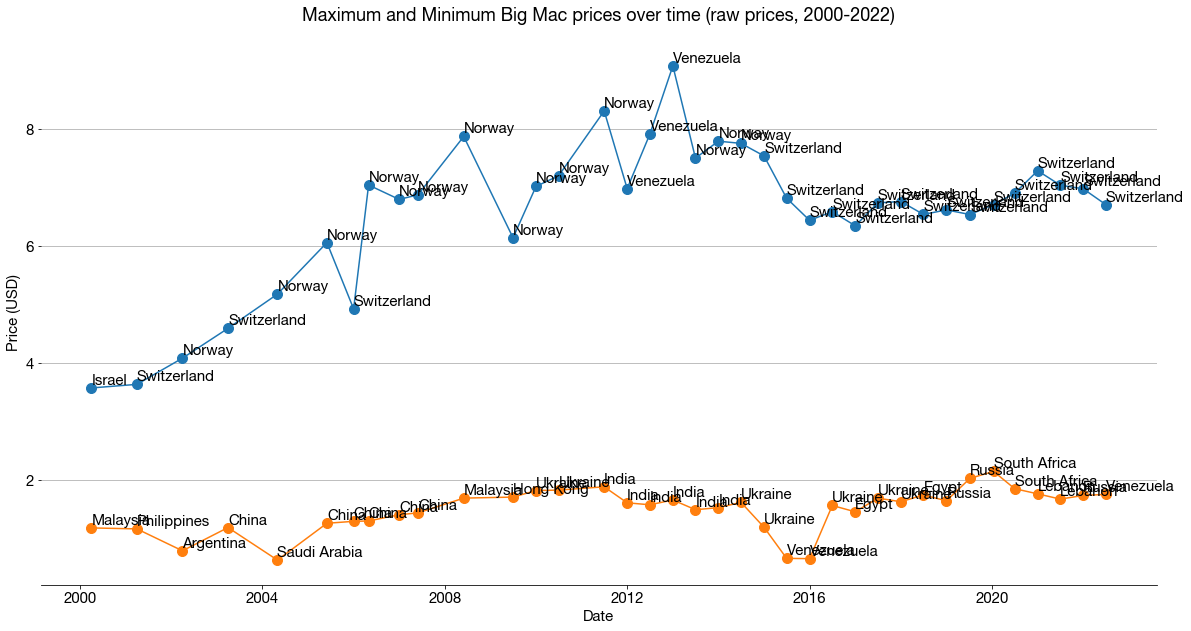

In [38]:
# Graphing data
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_price_max["date"], df_price_max["dollar_price"], marker=".", markersize=20)
for index, row in df_price_max.iterrows():
    ax.text(row["date"], row["dollar_price"], row["name"], verticalalignment='bottom') # Label each data point with country name

ax.plot(df_price_min["date"], df_price_min["dollar_price"], marker=".", markersize=20)
for index, row in df_price_min.iterrows():
    ax.text(row["date"], row["dollar_price"], row["name"], verticalalignment='bottom') # Label each data point with country name

ax.set_title("Maximum and Minimum Big Mac prices over time (raw prices, 2000-2022)", pad=20)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
# ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(color='grey', axis="y", linestyle='-', linewidth=1, alpha=0.5) # alpha = opacity
ax.spines.left.set_visible(False) # Remove margins
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)  

# Extension: Use country codes instead of names, so data labels look tidier on graph

#### Observations:
- Lowest Big Mac price has remained relatively stable over 20+ years, at just under 2USD
- Norway and Switzerland lead in most expensive Big Mac
    - However, price of most expensive Big Mac hasn't changed much in recent years. This could be due to pressure from other food options — if you charge 10USD for a Big Mac, customers will buy something else instead.
- Venezuela has gone from having the most expensive Big Mac to the least expensive (due to inflation and exchange rate issues)
- Seems like globalization has not had any significant impact on reducing price differences between countries (i.e. the range between the cheapest and most expensive Big Mac)

Let's plot the same graph with adjusted prices and see if anything changes.

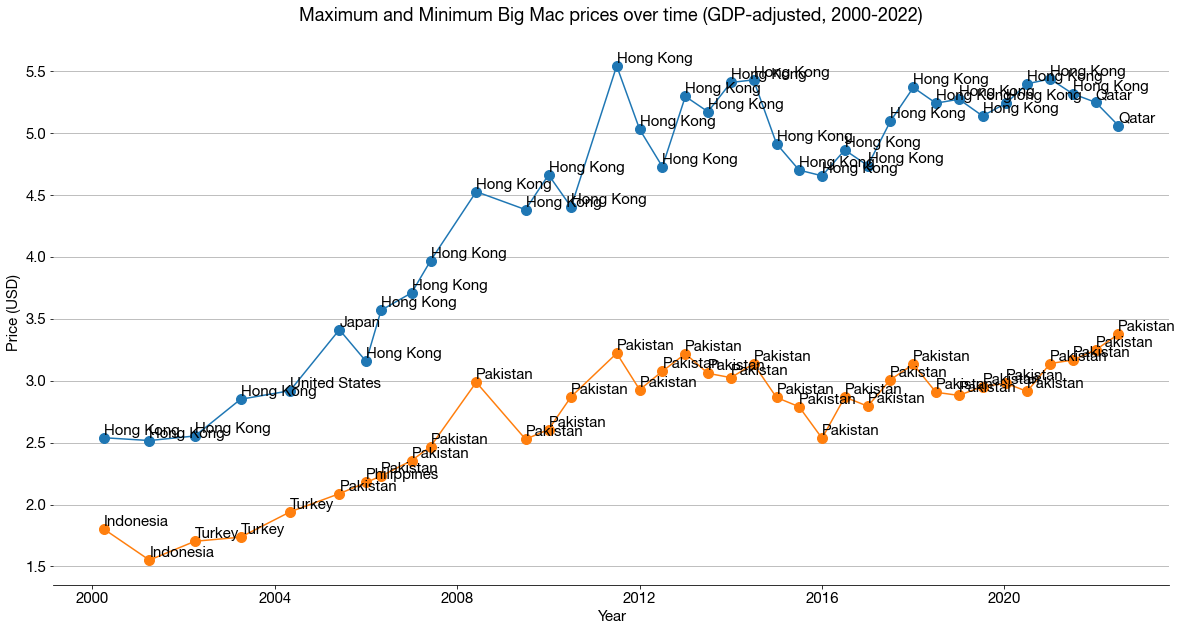

In [39]:
# Luckily, did not have to do data cleaning — some entries have raw prices but not GDP-adjusted prices, but null values won't interfere with selecting a min/max price
dates = df["date"].unique()
df_price_max = []
df_price_min = []
for date in dates:
    df_date = df.loc[df["date"] == date, ["date", "name", "adj_price"]]
    max_row = df_date.loc[df_date["adj_price"] == df_date["adj_price"].max()] # Select row where dollar_price is max
    df_price_max.append(max_row)
    min_row = df_date.loc[df_date["adj_price"] == df_date["adj_price"].min()]
    df_price_min.append(min_row)
df_price_max = pd.concat(df_price_max)
df_price_max = df_price_max.reset_index(drop=True)
df_price_min = pd.concat(df_price_min)
df_price_min = df_price_min.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_price_max["date"], df_price_max["adj_price"], marker=".", markersize=20)
for index, row in df_price_max.iterrows():
    ax.text(row["date"], row["adj_price"], row["name"], verticalalignment='bottom') # Label each data point with country name

ax.plot(df_price_min["date"], df_price_min["adj_price"], marker=".", markersize=20)
for index, row in df_price_min.iterrows():
    ax.text(row["date"], row["adj_price"], row["name"], verticalalignment='bottom') # Label each data point with country name

ax.set_title("Maximum and Minimum Big Mac prices over time (GDP-adjusted, 2000-2022)", pad=20)
ax.set_xlabel("Year")
ax.set_ylabel("Price (USD)")
ax.grid(color='grey', axis="y", linestyle='-', linewidth=1, alpha=0.5) # alpha = opacity
ax.spines.left.set_visible(False) # Remove margins
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)  


#### Observations:
- Hong Kong consistently has the highest adjusted prices
    - This means a Big Mac is least 'worth it' in Hong Kong (not to mention the size — what part of a Big Mac is 'big'?)
    - We'll ignore Qatar since they were only recently added to the Big Mac Index (not much data for Qatar)
- Pakistan has the lowest adjusted prices in recent years
- Gap between adjusted prices has widened in recent years, suggesting differences in countries' purchasing power has also widened
- Comparing to the graph for raw prices:
    - The range between adjusted prices is lower than raw prices
        - This makes sense, as adjusting prices for GDP is supposed to somewhat equalize price levels in different countries. In other words, a Big Mac should cost around the same regardless of where it's sold, as the value it provides is the same (one Big Mac). 
    - Countries with the highest raw price don't necessarily have the highest adjusted price (same for lowest)
    
Although Hong Kong has one of the lowest Big Mac raw prices globally at 2.8USD (even having the world's lowest price in 2010), it has one of the most expensive Big Macs after price adjustment, suggesting a Big Mac actually costs the most in Hong Kong in terms of purchasing power. Is there any reason Big Macs cost more in Hong Kong?


### iii. How do Big Mac prices show changes in purchasing power?

To compare changes in purchasing power in Hong Kong, I will compare changes in Big Mac prices to changes in inflation and average household income. 

Purchasing power depends on the relative change between price levels (Big Mac price/inflation) and income. If you have more income, your purchasing power goes up (as you can now buy more things), but if price levels go up, your purchasing power goes down (as it costs more to buy the same goods and services). 

More info: https://en.wikipedia.org/wiki/Purchasing_power

In [40]:
# Preparing relevant data
# Big Mac raw price in 2000; base price to compare to
big_mac_2000_price = df.loc[(df["date"].dt.year.between(2000, 2022)) & (df["name"] == "Hong Kong")].iloc[0]["dollar_price"] 

# Group raw price by average for each year (to smooth out data and to have data dates comparable)
    # https://stackoverflow.com/questions/67828239/how-to-show-to-average-sales-for-each-year-within-ten-years-for-a-specific-city
df_indexes = df.loc[(df["date"].dt.year.between(2000, 2022)) & (df["name"] == "Hong Kong")] \
  .groupby([pd.Grouper(key="date", freq="YS")])["dollar_price"].mean()
df_indexes = pd.DataFrame(df_indexes).reset_index()
df_indexes["dollar_price"] = df_indexes["dollar_price"] / df_indexes.iloc[0]["dollar_price"] # Convert dollar prices to percentage change from first entry

# Group adjusted price by average for each year
adj_prices = df.loc[(df["date"].dt.year.between(2000, 2022)) & (df["name"] == "Hong Kong")] \
  .groupby([pd.Grouper(key="date", freq="YS")])["adj_price"].mean()
adj_prices = adj_prices.reset_index(drop=True) # Drop index to merge with df_indexes
df_indexes = pd.concat([df_indexes, pd.DataFrame({"adj_price": adj_prices})], axis=1)
df_indexes["adj_price"] = df_indexes["adj_price"] / df_indexes.iloc[0]["adj_price"] # Convert dollar prices to percentage change from first entry

# Hong Kong 2000-2021 inflation data (Composite Consumer Price Index), from https://www.censtatd.gov.hk/en/web_table.html?id=52#
    # Not a best practice, but it was easier to copy paste data than to download Excel and extract data from there
inflation_index = [73.6, 70.9, 69.8, 67.6, 65.9, 65.6, 66.2, 67.6, 68.9, 71.9, 72.3, 74.0, 77.9, 81.1, 84.6, 88.3, 91.0, 93.2, 94.6, 96.8, 99.6, 99.9, 101.4]
inflation_index = [x / inflation_index[0] for x in inflation_index] # Convert index figures to percentage change from first entry
df_indexes = pd.concat([df_indexes, pd.DataFrame({"inflation": inflation_index})], axis=1) # Convert list to dataframe, combine columns together
# df_indexes["date"] = pd.date_range(start='1/1/2000', periods=len(df_indexes), freq='YS') # Add dates to dataframe, starting from year 2000, freq = start of year

# Hong Kong 2000-2021 household income data (HKD), from https://www.censtatd.gov.hk/en/web_table.html?id=5
household_income = [17500, 18000, 18000, 17000, 16000, 16000, 16000, 17000, 17500, 18400, 18000, 18000, 20000, 21000, 22200, 23200, 24800, 25200, 26600, 28500, 29000, 27500, 27500]
household_income = [x / household_income[0] for x in household_income] # Convert income figures to percentage change from first entry
df_household = pd.DataFrame({"household_income": household_income})
df_indexes = pd.concat([df_indexes, df_household], axis=1) # Combine dataframes together, by column

# Hong Kong domestic property market price indices, data from https://www.rvd.gov.hk/en/publications/property_market_statistics.html
property_prices = [100, 89.6, 78.7, 69.9, 61.6, 78.0, 92.0, 92.7, 103.5, 120.5, 121.3, 150.9, 182.1, 206.2, 242.4, 256.9, 296.8, 286.1, 333.9, 377.3, 383.0, 381.2, 392.7]
property_prices = [x / property_prices[0] for x in property_prices]
df_indexes = pd.concat([df_indexes, pd.DataFrame({"property_prices": property_prices})], axis=1)

# S&P 500 historical returns, data from https://www.investopedia.com/ask/answers/042415/what-average-annual-return-sp-500.asp#toc-sp-500-historical-returns (no Excel, copy pasted data)
sp_500_yearly_change = [0, -9.03, -11.85, -21.97, 28.36, 10.74, 4.83, 15.61, 5.48, -36.55, 25.94, 14.82, 2.10, 15.89, 32.15, 13.52, 1.38, 11.77, 21.61, -4.23, 31.21, 18.02, 28.47]
curr = 1
sp_500_absolute_change = []
for percentage_change in sp_500_yearly_change:
    curr *= (1 + percentage_change / 100)
    sp_500_absolute_change.append(curr)
df_indexes = pd.concat([df_indexes, pd.DataFrame({"sp_500": sp_500_absolute_change})], axis=1)

df_indexes 
# Shows how much a dollar in 2000 would be worth now, if the value of a dollar changed according to that index

date  dollar_price  adj_price  inflation  household_income  \
0  2000-01-01      1.000000   1.000000   1.000000          1.000000   
1  2001-01-01      1.047675   0.991143   0.963315          1.028571   
2  2002-01-01      1.069216   1.005611   0.948370          1.028571   
3  2003-01-01      1.126006   1.122348   0.918478          0.971429   
4  2004-01-01      1.176471   1.138106   0.895380          0.914286   
5  2005-01-01      1.177877   1.329846   0.891304          0.914286   
6  2006-01-01      1.182199   1.324181   0.899457          0.914286   
7  2007-01-01      1.173910   1.512064   0.918478          0.971429   
8  2008-01-01      1.302684   1.782884   0.936141          1.000000   
9  2009-01-01      1.310567   1.725681   0.976902          1.051429   
10 2010-01-01      1.455584   1.785309   0.982337          1.028571   
11 2011-01-01      1.480050   2.182916   1.005435          1.028571   
12 2012-01-01      1.623326   1.921502   1.058424          1.142857   
13 2013-01-01      1.673568   2.061517   1.101902          1.200000   
14 2014-01-01      1.812281   2.134377   1.149457          1.268571   
15 2015-01-01      1.872100   1.893413   1.199728          1.325714   
16 2016-01-01      1.891123   1.874357   1.236413          1.417143   
17 2017-01-01      1.883894   1.936206   1.266304          1.440000   
18 2018-01-01      1.974291   2.089282   1.285326          1.520000   
19 2019-01-01      1.977107   2.050403   1.315217          1.628571   
20 2020-01-01      2.016760   2.095215   1.353261          1.657143   
21 2021-01-01      2.041068   2.117790   1.357337          1.571429   
22 2022-01-01      2.098937   1.981771   1.377717          1.571429   

    property_prices    sp_500  
0             1.000  1.000000  
1             0.896  0.909700  
2             0.787  0.801901  
3             0.699  0.625723  
4             0.616  0.803178  
5             0.780  0.889439  
6             0.920  0.932399  
7             0.927  1.077947  
8             1.035  1.137018  
9             1.205  0.721438  
10            1.213  0.908579  
11            1.509  1.043231  
12            1.821  1.065138  
13            2.062  1.234389  
14            2.424  1.631245  
15            2.569  1.851789  
16            2.968  1.877344  
17            2.861  2.098307  
18            3.339  2.551752  
19            3.773  2.443812  
20            3.830  3.206526  
21            3.812  3.784342  
22            3.927  4.861745

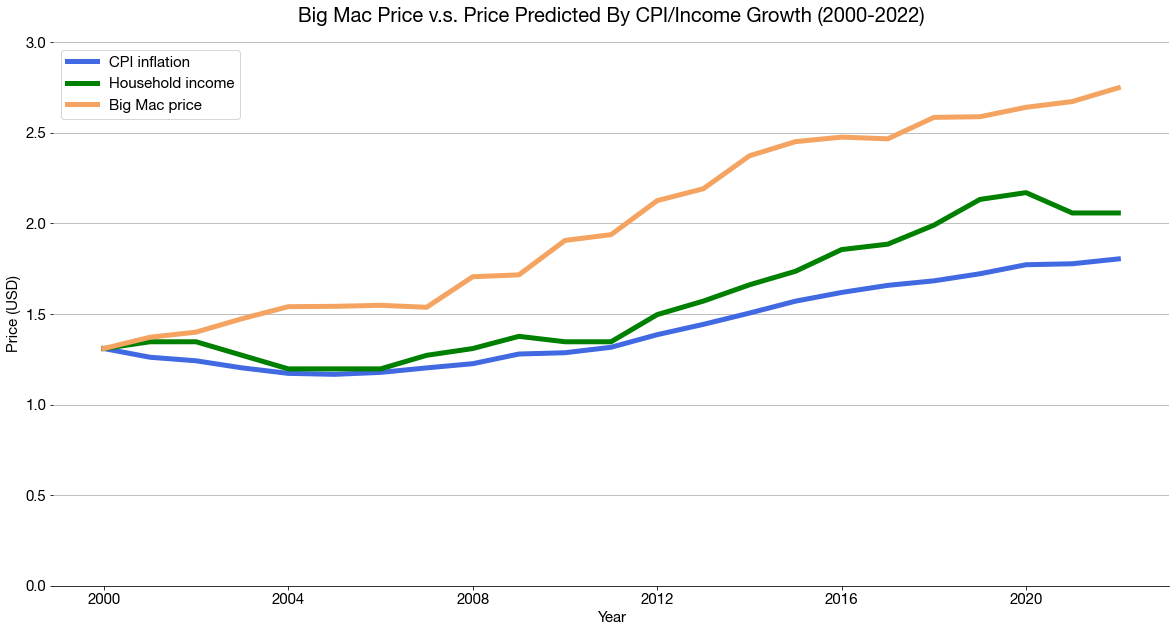

In [41]:
# Graphing data
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_indexes["date"], big_mac_2000_price * df_indexes["inflation"], linewidth=5, color='royalblue', label="CPI inflation") # Multiply index by base price to see how base price would change, if it followed inflation growth
ax.plot(df_indexes["date"], big_mac_2000_price * df_indexes["household_income"], linewidth=5, color='g', label="Household income")
ax.plot(df_indexes["date"], big_mac_2000_price * df_indexes["dollar_price"], linewidth=5, color='sandybrown', label="Big Mac price")

ax.set_ylim([0, 3])
ax.set_title("Big Mac Price v.s. Price Predicted By CPI/Income Growth (2000-2022)", fontsize=20, pad=20)
ax.set_xlabel("Year")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(color='grey', axis="y", linestyle='-', linewidth=1, alpha=0.5) # alpha = opacity
ax.spines.left.set_visible(False) # Remove margins
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)  

### Observations:
- A Big Mac has gone up 110% in price in the past 20 years, while CPI (inflation) has gone up 37%
- If Big Mac prices followed the CPI rate of inflation, a Big Mac would cost ~1.9USD now instead of its current price of ~2.7USD
    - Actual cost is 42% higher than expected
    - Compared to 2000, your money today only buys 70% of a Big Mac on an inflation-adjusted basis
- Household income has grown at a higher rate than CPI inflation
    - In theory, purchasing power of Hong Kong citizens has gone up, due to quality improvements to products (e.g. better smartphones)
    - However, household income has grown 52% less than Big Mac prices, suggesting actual purchasing power has gone down despite Hong Kong having one of the cheapest Big Macs in the world

### Why does Big Mac price inflation differ from CPI inflation?
- CPI assumes consumers will substitute expensive items for cheaper ones
    - For example, if the price of a Big Mac goes up, CPI assumes consumers will switch to a regular Hamburger instead
- CPI factors in improvements of the quality of a product as lowering the price of a product, even though the 'sticker price' (the price we pay) hasn't changed

More info: https://www.altoonamirror.com/opinion/2021/07/big-mac-inflation-differs-from-cpi/

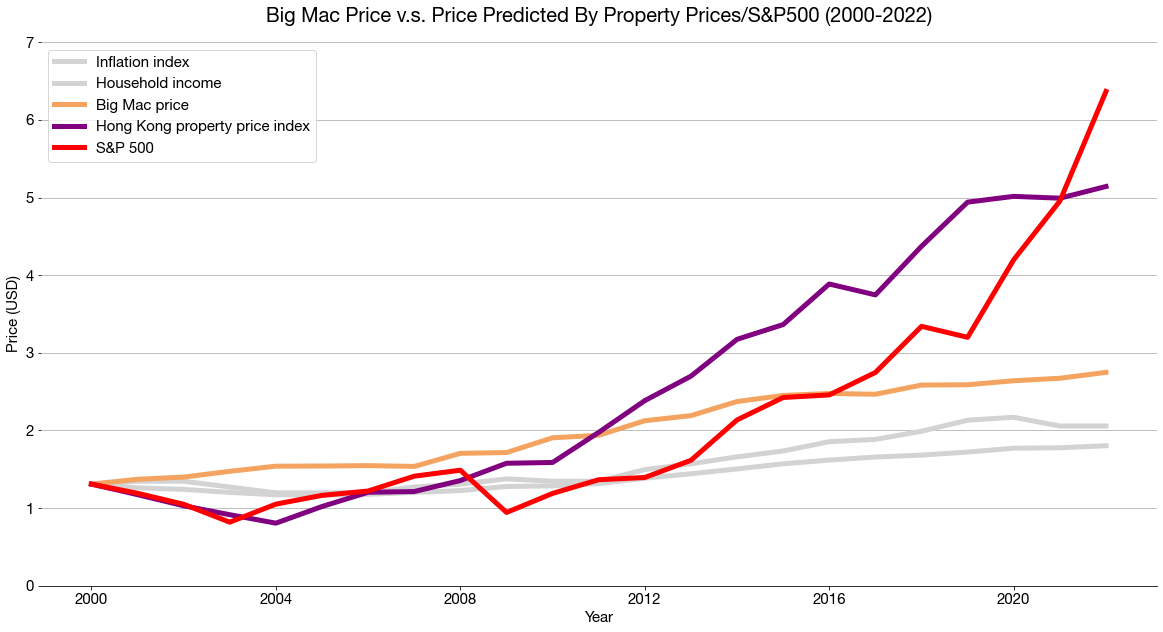

In [42]:
# Same graph, but with property price index and S&P 500 included 
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_indexes["date"], big_mac_2000_price * df_indexes["inflation"], linewidth=5, color='lightgrey', label="Inflation index") # Multiply index by base price to see how base price would change, if it followed inflation growth
ax.plot(df_indexes["date"], big_mac_2000_price * df_indexes["household_income"], linewidth=5, color='lightgrey', label="Household income")
ax.plot(df_indexes["date"], big_mac_2000_price * df_indexes["dollar_price"], linewidth=5, color='sandybrown', label="Big Mac price")
ax.plot(df_indexes["date"], big_mac_2000_price * df_indexes["property_prices"], linewidth=5, color='purple', label="Hong Kong property price index")
ax.plot(df_indexes["date"], big_mac_2000_price * df_indexes["sp_500"], linewidth=5, color='r', label="S&P 500")

ax.set_ylim([0, 7])
ax.set_title("Big Mac Price v.s. Price Predicted By Property Prices/S&P500 (2000-2022)", fontsize=20, pad=20)
ax.set_xlabel("Year")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(color='grey', axis="y", linestyle='-', linewidth=1, alpha=0.5) # alpha = opacity
ax.spines.left.set_visible(False) # Remove margins
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)  

### Observations:
- Hong Kong's official CPI inflation rate does not reflect actual prices consumers are paying
    - Food (represented by the Big Mac) and property make up a substantial part of living costs, but the CPI seems to be unable to capture their price increases
    - This is likely due to how CPI takes substitutes and quality improvements into account
- Although inflation in property and Big Mac prices are high, company values (represented by the S&P 500) have risen at an even higher rate

### Opinion/thoughts:
- Hong Kong's example might be the case for most countries — income growth is substantially lower than Big Mac price inflation, leading to a decrease in purchasing power and an increase in the relative cost for a Big Mac.
- This may be why the adjusted price for Big Macs rises over time, not because a Big Mac provides more value now than before (such as improvements to taste or nutrition), but because of how we need to pay a higher price to make up for the decrease in purchasing power. 

The relation between income growth, Big Mac price inflation, and CPI inflation can be examined for other countries, but this would require importing more data from many different sources. 

### D. Extra graphs
***

I mainly did these just for practice (also they look nicer than just line graphs), but they could have some findings that link to the observations above.

#### i. Correlation between Big Mac prices for different countries — heatmap (correlation matrix)

Text(0.5, 1.0, 'Correlation matrix for Big Mac raw prices')

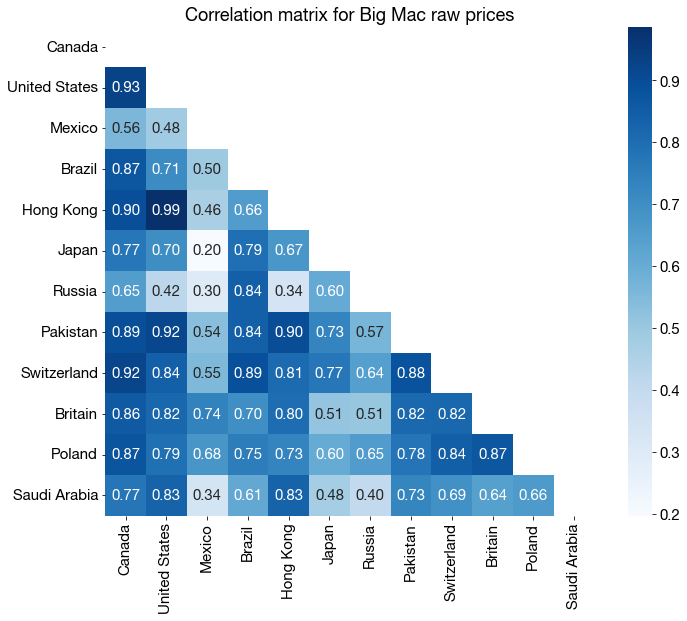

In [43]:
# Pick one/two countries from each area, otherwise too many countries on matrix
north_america_australia = ["Canada", "United States"]
south_america = ["Mexico", "Brazil"]
asia = ["Hong Kong", "Japan", "Russia"] 
south_east_asia = ["Pakistan"]
europe = ["Switzerland", "Britain"]
east_europe = ["Poland"] 
africa_middle_east = ["Saudi Arabia"]
countries = north_america_australia + south_america + asia + south_east_asia + europe + east_europe + africa_middle_east

# Create dataframe to store prices of countries
df_prices = pd.DataFrame({"date": df["date"].unique()}).reset_index(drop=True)

for country in countries:
    df_country = pd.DataFrame({country: df.loc[df["name"] == country]["dollar_price"].reset_index(drop=True)})
    df_prices = pd.concat([df_prices, df_country], axis=1)

# Generate correlation matrix
corr = df_prices.corr()

# Generate mask for correlation matrix, only showing the bottom left triangle instead of a whole square
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(
    corr,          # Plot out correlation matrix calculated in previous step
    mask=mask,     # Only show squares according to mask
    square=True,   # Make each cell square shaped
    fmt=".2f",     # Format for annotations
    annot=True,    # Write data value in each cell
    cmap="Blues"   # Change colors used
)
ax.set_title("Correlation matrix for Big Mac raw prices")

Text(0.5, 1.0, 'Correlation matrix for Big Mac adjusted prices')

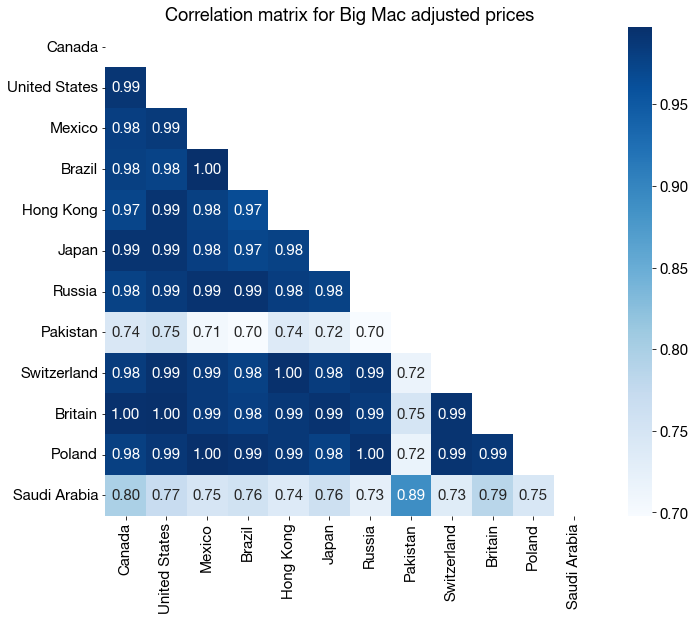

In [44]:
# Same thing, but for adjusted prices
# Create dataframe to store prices of countries
df_prices = pd.DataFrame({"date": df["date"].unique()}).reset_index(drop=True)

for country in countries:
    df_country = pd.DataFrame({country: df.loc[df["name"] == country]["adj_price"].reset_index(drop=True)})
    df_prices = pd.concat([df_prices, df_country], axis=1)

# Generate correlation matrix
corr = df_prices.corr()

# Generate mask for correlation matrix, only showing the bottom left triangle instead of a whole square
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(
    corr,          # Plot out correlation matrix calculated in previous step
    mask=mask,     # Only show squares according to mask
    square=True,   # Make each cell square shaped
    fmt=".2f",     # Format for annotations
    annot=True,    # Write data value in each cell
    cmap="Blues"   # Change colors used
)
ax.set_title("Correlation matrix for Big Mac adjusted prices")

Similar to our line graph above, the correlation matrix shows that adjusted prices have a higher correlation compared to raw prices. 

For some reason, Pakistan and Saudi Arabia have lower correlations with other countries — not too sure what this means, as a correlation of 0.70-0.80 is still relatively high, just not as highly correlated as the other countries.

#### ii.  Changes in Big Mac prices for various countries — horizontal bar graph

In [45]:
# Prepare data
bar_graph_raw = {}
for country in countries:
    df_temp = df.loc[df["name"] == country]["dollar_price"]
    bar_graph_raw[country] = 100 * (df_temp.iloc[-1] - df_temp.iloc[0]) / df_temp.iloc[0]

bar_graph_adj = {}
for country in countries:
    df_temp = df.loc[df["name"] == country]["adj_price"]
    bar_graph_adj[country] = 100 * (df_temp.iloc[-1] - df_temp.iloc[0]) / df_temp.iloc[0]

# Sort dictionary based on values
bar_graph_raw = {k: v for k, v in sorted(bar_graph_raw.items(), key=lambda item: item[1], reverse=True)}

# Use seaborn instead
# Create dataframe with relevant data
dollar_prices = pd.DataFrame.from_dict(bar_graph_raw, orient="index").reset_index()
dollar_prices = dollar_prices.rename(columns={"index": "name", 0: "dollar_price"}) # Rename columns

adj_prices = pd.DataFrame.from_dict(bar_graph_adj, orient="index").reset_index()
adj_prices = adj_prices.rename(columns={"index": "name", 0: "adj_price"}) # Rename columns

df_bar = pd.merge(dollar_prices, adj_prices, on='name', how='outer')
df_bar = df_bar.rename(columns={'dollar_price': 'Dollar price', 'adj_price': 'Adjusted price'}) # Rename columns for legend labels 

# Melt dataframe so seaborn can separate by hue
df_bar = pd.melt(df_bar, id_vars="name", value_vars=["Dollar price", "Adjusted price"])

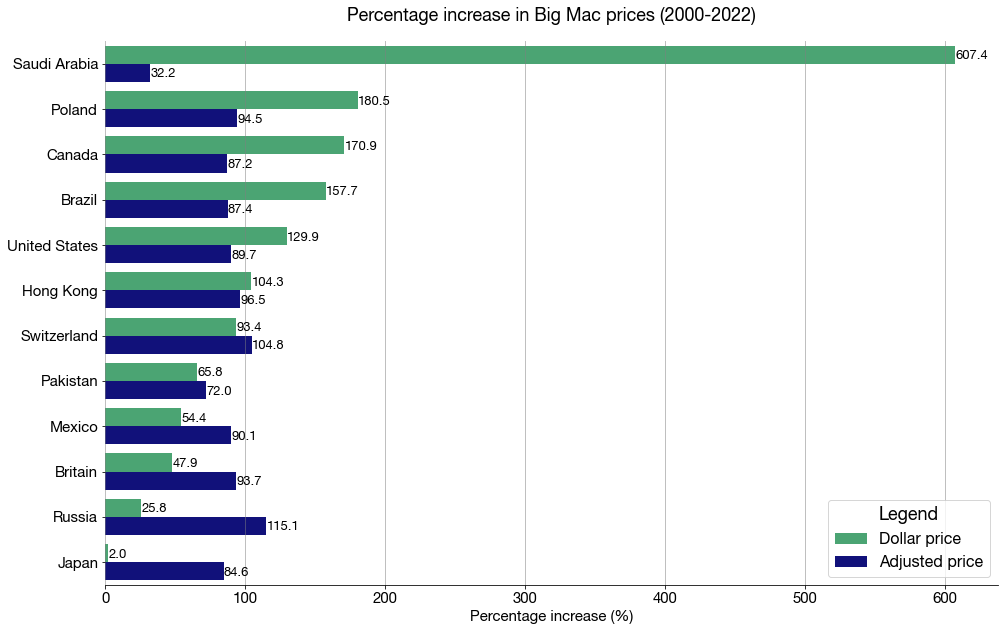

In [46]:
# Plot horizontal bar graph with seaborn
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x="value", y="name", data=df_bar, hue="variable", palette=["mediumseagreen", "darkblue"])

# Annotate each bar with value
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y() + 0.3,
             str(round((i.get_width()), 1)),
             fontsize = 13, fontweight ='bold',
             color ='black')

# Stylize graph
ax.set_title("Percentage increase in Big Mac prices (2000-2022)", pad=20)
ax.set_xlabel("Percentage increase (%)")
ax.set_ylabel("")
ax.grid(color='grey', axis="x", linestyle='-', linewidth=1, alpha=0.5) # alpha = opacity
ax.legend(title="Legend", title_fontsize=18, fontsize=16)
ax.spines.left.set_visible(False) # Remove margins
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False) 


### Observations:
- Although Saudi Arabia has had a 600% increase in raw Big Mac prices, its adjusted price has only risen by 32.2%
    - The raw price suggests that price levels have gone up significantly, but the adjusted prices suggest that income growth has matched increases in price levels
- Japan has the opposite scenario: nearly no increase in raw Big Mac prices, but an increase in 85% for adjusted prices
    - Japan is said to be in constant deflation, since companies are afraid of scaring customers away if they increase prices. However, the increase in adjusted prices suggest that Japan's purchasing power has decreased, possibly due to its weak currency (meaning Japan's purchasing power has decreased relative to other countries).

#### iii. Big Mac prices on a choropleth map

In [47]:
# Use Plotly, followed example on https://medium.com/@282abhishek/creating-an-animated-world-map-timeline-with-plotly-choropleth-57398324290
# df_plotly created above — same as df, but date column uses string instead of datetime datatype
fig = px.choropleth(df_plotly, locations="iso_a3",
                    color="dollar_price",
                    hover_name="name",
                    hover_data = { # Include/exclude data when hovering over a country
                        "dollar_price": True,
                        "date": False,
                        "iso_a3": False,
                    },
                    locationmode="ISO-3", # Use ISO-3 to label countries on map
                    animation_frame="date", # Animate choropleth by date
                    color_continuous_midpoint = 4, # Set midpoint of color scale to 4USD, otherwise colors will keep changing based on min/max range of that date
                    color_continuous_scale=px.colors.sequential.haline_r, # Change colors of choropleth, see https://plotly.com/python/builtin-colorscales/
                    labels={
                     "dollar_price": "Price (USD) ",
                    },
                    )

fig.update_layout(margin=dict(l=20,r=0,b=0,t=50,pad=0),
                    paper_bgcolor="white",
                    width=1600,
                    height=800,
                    title_text = 'Big Mac raw prices',
                    font_size=18,
                    font_family = "Helvetica Neue"
                    )

fig.show()

In [48]:
# Same thing, but using adjusted prices instead
fig = px.choropleth(df_plotly, locations="iso_a3",
                    color="adj_price",
                    hover_name="name",
                    hover_data = {
                        "adj_price": True,
                        "dollar_price": True,
                        "date": False,
                        "iso_a3": False,
                    },
                    locationmode="ISO-3", 
                    animation_frame="date",
                    color_continuous_midpoint = 3.5, # Set midpoint of color scale to 2.5USD, otherwise colors will keep changing based on min/max range of that date
                    color_continuous_scale=px.colors.sequential.Sunset, # Different color used to make it clear this is a different choropleth map
                    labels={
                     "adj_price": "Adjusted price (USD) ",
                     "dollar_price": "Raw price (USD): "
                    },
                    )

fig.update_layout(margin=dict(l=20,r=0,b=0,t=70,pad=0),
                    paper_bgcolor="white",
                    width=1600,
                    height=800,
                    title_text = 'Big Mac adjusted prices',
                    font_size=18,
                    font_family = "Helvetica Neue"
                    )

fig.show()

In general, if a country's economy is more developed, it seems that their Big Mac raw prices and adjusted prices are higher too (US, Western Europe compared to South America, Asia).

## Summary
***
### Key findings
- How do Big Mac prices differ over time?
    - Big Mac raw prices have gone up in general, but the trend depends on the country and their exchange rate to USD
        - Some countries have abnormal trends
            - For example, Japan's raw Big Mac price has stagnated at under 3USD the past 20 years
            - Venezuela's Big Mac prices looks more like a rollercoaster due to inflation/currency exchange rate issues
    - Big Mac adjusted prices have gone up similarly across all countries, roughly doubling over the past 20 years
        - If Big Mac adjusted prices are reflective of overall price levels, this suggests that purchasing power for consumers has halved (?)
<!-- -->
- Which countries have the cheapest/most expensive Big Macs?
    - Raw price ('sticker' price, what you actually pay)
        - Norway and Switzerland have some of the most expensive Big Macs, at ~6.7USD in 2022
        - Asian/African and Middle Eastern countries have some of the cheapest Big Macs, at ~2.2USD in 2022
    - Adjusted price (adjusting for GDP per capita)
        - Hong Kong has the most expensive Big Mac in relation to purchasing power, at ~5.0USD in 2022
        - Pakistan has the cheapest Big Mac in relation to purchasing power, at ~3.3USD in 2022
<!-- -->
- How do Big Mac prices show changes in purchasing power (using Hong Kong as an example)?
    - CPI inflation (the inflation rate often shown in the news and used for banking loans/economic planning) is lower than growth in actual prices that consumers have to pay
        - Compared to 2000, your money today only buys 70% of a Big Mac (after adjusting for inflation)
        - CPI takes substitution and quality improvements into account, but consumers 'feel' actual price increases more than the CPI implied rate
    - Household income has grown at a higher rate than CPI inflation, but at a lower rate than Big Mac prices
        - This suggests that purchasing power has actually gone down, since income growth is below growth in prices
    - A Big Mac has gone up 110% in price in the past 20 years, while CPI (inflation) has gone up 37%

### Limitations

- Various factors affect the price of a Big Mac, not just changes in general price levels
    - For example, McDonalds may set different profit margins for each country, leading to different prices
        - Makes sense for lower-margin, higher volume in developing economies and higher-margin in developed economies, leading to higher prices in North America/Western Europe
- Big Mac price levels may not generalize to changes in purchasing power for consumers
    - Other than food, consumers also spend on other areas like housing, energy, recreation — Big Mac price changes are unable to capture price level changes in these areas, unlike the basket of goods used for CPI
- Limited data
    - Limited countries covered by dataset, especially in Africa
    - Limited time period (from 2000 onwards)
        - The Economist has data ranging back to 1986, but that would require merging dataframes and cleaning data

## Miscellaneous
***

### Extensions

- Compare changes in CPI inflation and Big Mac prices for other countries
    - Big Macs are more comparable across countries than basket of goods used in CPI calculations
- Link findings to data measuring quality of life e.g. Human Development Index, unemployment
    - Do changes in purchasing power/inflation correlate with quality of life? 
        - For example, if inflation goes up, does quality of life go down measurably?

### Inspiration
- Big Mac Index data analysis projects
    - [R for Data Science — Tidy Tuesday project](https://youtu.be/pxJ5wtxL5Kw?t=3654)
    - [Big Mac Index across US states](https://pantryandlarder.com/big-mac-inflation/)
    - [US Big Mac prices v.s. inflation](https://medium.datadriveninvestor.com/what-do-big-mac-prices-tell-us-about-true-inflation-27f44912500f)
- https://www.reddit.com/r/learnpython/comments/ggu2mb/beginner_python_data_analysis_project_critique/ for how to organize a data analysis project

### Graphing style
- Inspired by Datawrapper style (example: https://medium.datadriveninvestor.com/what-do-big-mac-prices-tell-us-about-true-inflation-27f44912500f)
- Font: Helvetica Neue 
- No top, left, right margins
- Default font size changed to 15 for larger labels
- Color reference: https://matplotlib.org/stable/gallery/color/named_colors.html (named CSS colors)
***